In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
xls = pd.ExcelFile('/content/E-commerce_data.xlsx')

In [4]:
customers = pd.read_excel(xls, 'customers')
transactions = pd.read_excel(xls, 'transactions')
genders = pd.read_excel(xls, 'genders')
cities = pd.read_excel(xls, 'cities')

In [5]:
customers["join_date"] = pd.to_datetime(customers["join_date"])
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
transactions["burn_date"] = pd.to_datetime(transactions["burn_date"])

In [6]:
transactions_per_customer = transactions.groupby("customer_id").size().reset_index(name="total_transactions")
burned_per_customer = transactions[transactions["transaction_status"] == "burned"].groupby("customer_id").size().reset_index(name="burned_coupons")
last_transaction = transactions.groupby("customer_id")["transaction_date"].max().reset_index(name="last_transaction")

In [9]:
customer_data = customers.merge(transactions_per_customer, on="customer_id", how="left")\
                         .merge(burned_per_customer, on="customer_id", how="left")\
                         .merge(last_transaction, on="customer_id", how="left")
customer_data["total_transactions"].fillna(0, inplace=True)
customer_data["burned_coupons"].fillna(0, inplace=True)
customer_data["last_transaction"].fillna(customer_data["last_transaction"].min(), inplace=True)

<ipython-input-9-ee968cc14b8c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["total_transactions"].fillna(0, inplace=True)
<ipython-input-9-ee968cc14b8c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [10]:
customer_data["recency_days"] = (customer_data["last_transaction"].max() - customer_data["last_transaction"]).dt.days
customer_data.drop(columns=["join_date", "last_transaction"], inplace=True)
features = ["total_transactions", "burned_coupons", "recency_days"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[features])


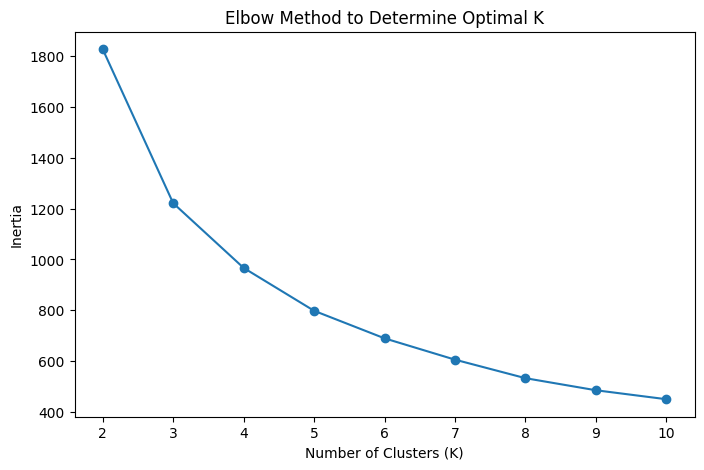

In [12]:
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal K")
plt.show()

In [13]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data["cluster"] = kmeans.fit_predict(scaled_data)
cluster_analysis = customer_data.groupby("cluster")[features].mean()


<ipython-input-14-281767b5a1ab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_analysis.index, y=cluster_analysis[feature], ax=axes[i], palette="coolwarm")
<ipython-input-14-281767b5a1ab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_analysis.index, y=cluster_analysis[feature], ax=axes[i], palette="coolwarm")
<ipython-input-14-281767b5a1ab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_analysis.index, y=cluster_analysis[feature], ax=axes[i], palette="coolwarm")


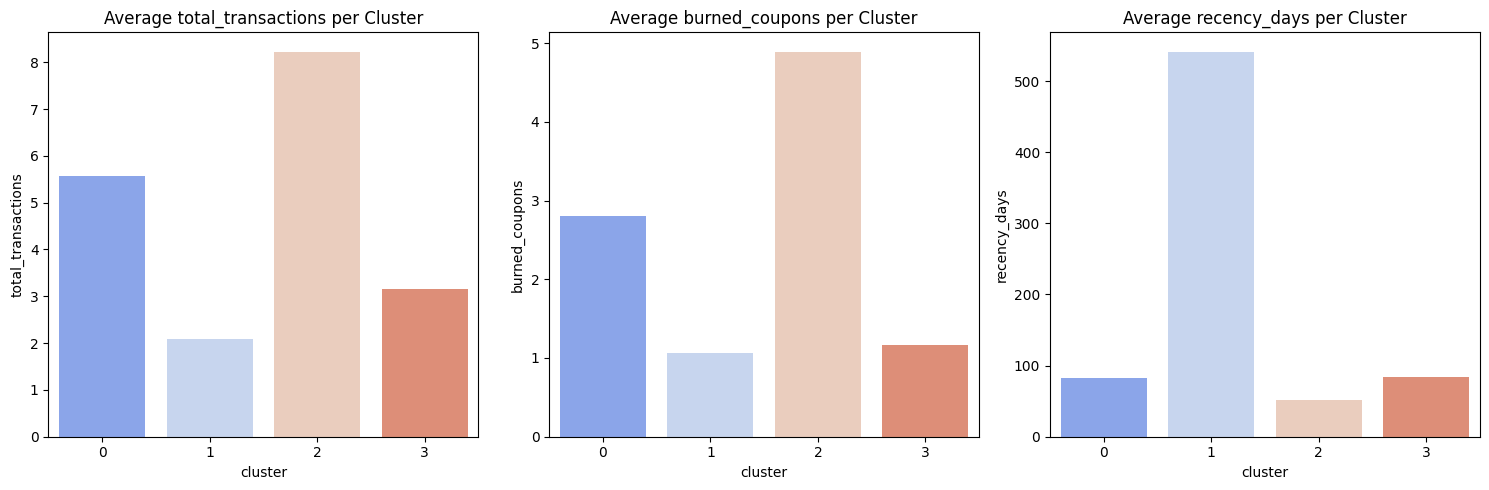

         total_transactions  burned_coupons  recency_days
cluster                                                  
0                  5.574419        2.804651     82.302326
1                  2.095238        1.059524    541.583333
2                  8.227273        4.892045     51.289773
3                  3.158065        1.161290     83.954839


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(features):
    sns.barplot(x=cluster_analysis.index, y=cluster_analysis[feature], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"Average {feature} per Cluster")
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()
print(cluster_analysis)
